## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [ ]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [ ]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  val_last_window_size = val_data[-window_size:]
  test_data_extended = np.concatenate((val_last_window_size, test_data), axis=0)

  train_windows, train_targets = create_dataset(train_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)
  test_windows, test_targets = create_dataset(test_data_extended, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [ ]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-17 00:14:12,472] A new study created in memory with name: no-name-e9fdf6a5-685f-4ec9-93a2-dbc366312878


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:14:35,890] Trial 0 finished with value: 89.62931613761612 and parameters: {'window_size': 91, 'tcn_filters': 72, 'tcn_kernel_size': 5, 'dropout_rate': 0.49332150860007373, 'attention_dim': 28}. Best is trial 0 with value: 89.62931613761612.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:14:40,680] Trial 1 finished with value: 92.28042695074669 and parameters: {'window_size': 90, 'tcn_filters': 45, 'tcn_kernel_size': 4, 'dropout_rate': 0.4994775233269291, 'attention_dim': 29}. Best is trial 0 with value: 89.62931613761612.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:14:52,256] Trial 2 finished with value: 22.40075635281199 and parameters: {'window_size': 78, 'tcn_filters': 110, 'tcn_kernel_size': 5, 'dropout_rate': 0.32423857643155396, 'attention_dim': 22}. Best is trial 2 with value: 22.40075635281199.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:14:59,903] Trial 3 finished with value: 52.460097654504686 and parameters: {'window_size': 51, 'tcn_filters': 65, 'tcn_kernel_size': 3, 'dropout_rate': 0.19109730415913917, 'attention_dim': 22}. Best is trial 2 with value: 22.40075635281199.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:15:11,448] Trial 4 finished with value: 117.95502550855225 and parameters: {'window_size': 73, 'tcn_filters': 54, 'tcn_kernel_size': 3, 'dropout_rate': 0.3606665220050814, 'attention_dim': 31}. Best is trial 2 with value: 22.40075635281199.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:15:16,725] Trial 5 finished with value: 5.577081574581174 and parameters: {'window_size': 18, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.11556771693066659, 'attention_dim': 10}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:15:28,276] Trial 6 finished with value: 24.212090638797793 and parameters: {'window_size': 97, 'tcn_filters': 73, 'tcn_kernel_size': 4, 'dropout_rate': 0.1958718363789163, 'attention_dim': 25}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:15:31,083] Trial 7 finished with value: 80.58290539182632 and parameters: {'window_size': 28, 'tcn_filters': 48, 'tcn_kernel_size': 3, 'dropout_rate': 0.4329055582259762, 'attention_dim': 13}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:15:41,740] Trial 8 finished with value: 43.98165814698978 and parameters: {'window_size': 77, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.2988242889433316, 'attention_dim': 12}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:15:47,215] Trial 9 finished with value: 18.354710765913847 and parameters: {'window_size': 27, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.14919559321307654, 'attention_dim': 18}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:15:53,966] Trial 10 finished with value: 23.313603776806 and parameters: {'window_size': 10, 'tcn_filters': 93, 'tcn_kernel_size': 4, 'dropout_rate': 0.1295822860779596, 'attention_dim': 8}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:15:59,277] Trial 11 finished with value: 8.144344445789022 and parameters: {'window_size': 31, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.11316143346987853, 'attention_dim': 16}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:16:06,880] Trial 12 finished with value: 13.731766977137683 and parameters: {'window_size': 37, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.10251014317556151, 'attention_dim': 15}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:16:12,225] Trial 13 finished with value: 23.72114108103544 and parameters: {'window_size': 10, 'tcn_filters': 97, 'tcn_kernel_size': 4, 'dropout_rate': 0.21856814315696965, 'attention_dim': 8}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:16:19,040] Trial 14 finished with value: 11.140440573216361 and parameters: {'window_size': 42, 'tcn_filters': 128, 'tcn_kernel_size': 3, 'dropout_rate': 0.11742392309109029, 'attention_dim': 17}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:16:23,444] Trial 15 finished with value: 19.16090032611232 and parameters: {'window_size': 21, 'tcn_filters': 89, 'tcn_kernel_size': 5, 'dropout_rate': 0.23883086500074233, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:16:33,191] Trial 16 finished with value: 30.60773039548091 and parameters: {'window_size': 59, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.15461534752465128, 'attention_dim': 15}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:16:44,892] Trial 17 finished with value: 12.241358810929256 and parameters: {'window_size': 42, 'tcn_filters': 103, 'tcn_kernel_size': 3, 'dropout_rate': 0.10296848775451051, 'attention_dim': 20}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:16:51,384] Trial 18 finished with value: 14.538243271762537 and parameters: {'window_size': 20, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.15858919364607563, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:16:58,052] Trial 19 finished with value: 43.736135154642916 and parameters: {'window_size': 53, 'tcn_filters': 34, 'tcn_kernel_size': 5, 'dropout_rate': 0.2557652533050917, 'attention_dim': 15}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:17:03,424] Trial 20 finished with value: 17.942964556080316 and parameters: {'window_size': 32, 'tcn_filters': 82, 'tcn_kernel_size': 2, 'dropout_rate': 0.16984352104109515, 'attention_dim': 10}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:17:10,790] Trial 21 finished with value: 10.712095134970095 and parameters: {'window_size': 44, 'tcn_filters': 128, 'tcn_kernel_size': 3, 'dropout_rate': 0.10392043655338092, 'attention_dim': 18}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:17:16,713] Trial 22 finished with value: 9.583195710296224 and parameters: {'window_size': 20, 'tcn_filters': 128, 'tcn_kernel_size': 3, 'dropout_rate': 0.1025408566846418, 'attention_dim': 18}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:17:23,367] Trial 23 finished with value: 8.897279675679721 and parameters: {'window_size': 18, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.1396575597851183, 'attention_dim': 20}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:17:27,313] Trial 24 finished with value: 6.7615778241299145 and parameters: {'window_size': 16, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.14691805416647577, 'attention_dim': 21}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:17:34,039] Trial 25 finished with value: 8.768388441927705 and parameters: {'window_size': 14, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.17214252452148837, 'attention_dim': 25}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:17:40,444] Trial 26 finished with value: 8.613902094375536 and parameters: {'window_size': 29, 'tcn_filters': 100, 'tcn_kernel_size': 4, 'dropout_rate': 0.14337489325206335, 'attention_dim': 24}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:17:52,361] Trial 27 finished with value: 13.762100413490446 and parameters: {'window_size': 36, 'tcn_filters': 109, 'tcn_kernel_size': 5, 'dropout_rate': 0.19324361802511786, 'attention_dim': 13}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:17:58,185] Trial 28 finished with value: 13.551462427238548 and parameters: {'window_size': 62, 'tcn_filters': 87, 'tcn_kernel_size': 4, 'dropout_rate': 0.13420497542897414, 'attention_dim': 21}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:18:05,168] Trial 29 finished with value: 7.253749709856114 and parameters: {'window_size': 24, 'tcn_filters': 121, 'tcn_kernel_size': 5, 'dropout_rate': 0.13108658241323903, 'attention_dim': 16}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:18:12,473] Trial 30 finished with value: 27.452180197252122 and parameters: {'window_size': 24, 'tcn_filters': 97, 'tcn_kernel_size': 5, 'dropout_rate': 0.21954154129409015, 'attention_dim': 27}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:18:16,453] Trial 31 finished with value: 6.056314357155528 and parameters: {'window_size': 16, 'tcn_filters': 119, 'tcn_kernel_size': 5, 'dropout_rate': 0.1296403740124412, 'attention_dim': 16}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:18:23,554] Trial 32 finished with value: 22.14858091218969 and parameters: {'window_size': 16, 'tcn_filters': 119, 'tcn_kernel_size': 5, 'dropout_rate': 0.17776710921172734, 'attention_dim': 14}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:18:30,410] Trial 33 finished with value: 8.81376219918364 and parameters: {'window_size': 14, 'tcn_filters': 112, 'tcn_kernel_size': 5, 'dropout_rate': 0.13280244061546584, 'attention_dim': 20}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:18:36,889] Trial 34 finished with value: 12.610987487140717 and parameters: {'window_size': 24, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.16082636401044592, 'attention_dim': 23}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:18:40,811] Trial 35 finished with value: 11.955740966720175 and parameters: {'window_size': 10, 'tcn_filters': 123, 'tcn_kernel_size': 5, 'dropout_rate': 0.127826145187668, 'attention_dim': 10}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:18:47,292] Trial 36 finished with value: 9.211329807995618 and parameters: {'window_size': 34, 'tcn_filters': 113, 'tcn_kernel_size': 5, 'dropout_rate': 0.17840036750633864, 'attention_dim': 19}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:19:02,678] Trial 37 finished with value: 15.454498281355182 and parameters: {'window_size': 68, 'tcn_filters': 107, 'tcn_kernel_size': 4, 'dropout_rate': 0.20394617970671547, 'attention_dim': 22}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:19:07,725] Trial 38 finished with value: 17.598922593045987 and parameters: {'window_size': 23, 'tcn_filters': 60, 'tcn_kernel_size': 5, 'dropout_rate': 0.15410353464662388, 'attention_dim': 29}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:19:19,354] Trial 39 finished with value: 11.092242874301853 and parameters: {'window_size': 84, 'tcn_filters': 122, 'tcn_kernel_size': 4, 'dropout_rate': 0.12373076553213751, 'attention_dim': 17}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:19:25,972] Trial 40 finished with value: 16.59952484596323 and parameters: {'window_size': 15, 'tcn_filters': 115, 'tcn_kernel_size': 4, 'dropout_rate': 0.18561858334935322, 'attention_dim': 13}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:19:32,555] Trial 41 finished with value: 9.418081589841586 and parameters: {'window_size': 28, 'tcn_filters': 122, 'tcn_kernel_size': 3, 'dropout_rate': 0.12038449723935499, 'attention_dim': 16}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:19:41,274] Trial 42 finished with value: 16.212007840245402 and parameters: {'window_size': 31, 'tcn_filters': 116, 'tcn_kernel_size': 5, 'dropout_rate': 0.14945423815251604, 'attention_dim': 16}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:19:52,848] Trial 43 finished with value: 24.316949999875785 and parameters: {'window_size': 26, 'tcn_filters': 78, 'tcn_kernel_size': 4, 'dropout_rate': 0.12061853265415677, 'attention_dim': 14}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:19:59,369] Trial 44 finished with value: 7.848349189009484 and parameters: {'window_size': 47, 'tcn_filters': 123, 'tcn_kernel_size': 3, 'dropout_rate': 0.10071081600233862, 'attention_dim': 17}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:20:11,765] Trial 45 finished with value: 18.500983283953534 and parameters: {'window_size': 45, 'tcn_filters': 100, 'tcn_kernel_size': 3, 'dropout_rate': 0.13891504348917227, 'attention_dim': 19}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:20:23,421] Trial 46 finished with value: 11.340840191163617 and parameters: {'window_size': 39, 'tcn_filters': 112, 'tcn_kernel_size': 3, 'dropout_rate': 0.10186314853604729, 'attention_dim': 9}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:20:35,036] Trial 47 finished with value: 6.967619451026504 and parameters: {'window_size': 49, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.12001324565529707, 'attention_dim': 31}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:20:39,349] Trial 48 finished with value: 25.564944101491395 and parameters: {'window_size': 13, 'tcn_filters': 68, 'tcn_kernel_size': 4, 'dropout_rate': 0.16855810697798257, 'attention_dim': 32}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:20:47,120] Trial 49 finished with value: 9.995525116262586 and parameters: {'window_size': 49, 'tcn_filters': 118, 'tcn_kernel_size': 4, 'dropout_rate': 0.14127462502738772, 'attention_dim': 28}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:20:58,722] Trial 50 finished with value: 27.09368913666846 and parameters: {'window_size': 96, 'tcn_filters': 91, 'tcn_kernel_size': 4, 'dropout_rate': 0.12033984832984483, 'attention_dim': 30}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:21:10,277] Trial 51 finished with value: 15.85978988217829 and parameters: {'window_size': 61, 'tcn_filters': 124, 'tcn_kernel_size': 3, 'dropout_rate': 0.11552834601804458, 'attention_dim': 12}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:21:16,731] Trial 52 finished with value: 13.198379463700542 and parameters: {'window_size': 19, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.15662917764390835, 'attention_dim': 26}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:21:29,351] Trial 53 finished with value: 11.435357971368962 and parameters: {'window_size': 56, 'tcn_filters': 120, 'tcn_kernel_size': 5, 'dropout_rate': 0.1290010367873726, 'attention_dim': 17}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:21:40,944] Trial 54 finished with value: 10.5252466043423 and parameters: {'window_size': 50, 'tcn_filters': 115, 'tcn_kernel_size': 3, 'dropout_rate': 0.1014533691674911, 'attention_dim': 14}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:21:51,963] Trial 55 finished with value: 13.903700108854586 and parameters: {'window_size': 66, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.14863265424115849, 'attention_dim': 23}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 8ms/step


[I 2023-06-17 00:22:03,674] Trial 56 finished with value: 15.984354055206147 and parameters: {'window_size': 46, 'tcn_filters': 127, 'tcn_kernel_size': 5, 'dropout_rate': 0.1674172675916258, 'attention_dim': 21}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:22:10,210] Trial 57 finished with value: 15.655326210850735 and parameters: {'window_size': 10, 'tcn_filters': 104, 'tcn_kernel_size': 3, 'dropout_rate': 0.11488566673511955, 'attention_dim': 15}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:22:22,218] Trial 58 finished with value: 19.700650564178396 and parameters: {'window_size': 40, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.13800189604571206, 'attention_dim': 19}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:22:33,432] Trial 59 finished with value: 26.65861745297427 and parameters: {'window_size': 55, 'tcn_filters': 121, 'tcn_kernel_size': 5, 'dropout_rate': 0.11339862580320112, 'attention_dim': 17}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:22:39,838] Trial 60 finished with value: 11.100314818058823 and parameters: {'window_size': 18, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.18891175697346552, 'attention_dim': 12}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:22:46,852] Trial 61 finished with value: 12.340494059293652 and parameters: {'window_size': 22, 'tcn_filters': 126, 'tcn_kernel_size': 2, 'dropout_rate': 0.10087735957246391, 'attention_dim': 16}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:22:53,256] Trial 62 finished with value: 13.5722769257063 and parameters: {'window_size': 30, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.13111934901027233, 'attention_dim': 16}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:22:59,746] Trial 63 finished with value: 19.48967212510039 and parameters: {'window_size': 26, 'tcn_filters': 124, 'tcn_kernel_size': 2, 'dropout_rate': 0.14934050436633953, 'attention_dim': 18}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:23:11,503] Trial 64 finished with value: 8.485944001442347 and parameters: {'window_size': 34, 'tcn_filters': 126, 'tcn_kernel_size': 2, 'dropout_rate': 0.11446381613773393, 'attention_dim': 15}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:23:17,756] Trial 65 finished with value: 9.061304121281154 and parameters: {'window_size': 17, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.160430725692632, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:23:24,517] Trial 66 finished with value: 16.21156307052846 and parameters: {'window_size': 13, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.13212525026005692, 'attention_dim': 8}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:23:31,016] Trial 67 finished with value: 12.107131421012786 and parameters: {'window_size': 21, 'tcn_filters': 101, 'tcn_kernel_size': 5, 'dropout_rate': 0.11306899175600782, 'attention_dim': 14}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 1s 4ms/step


[I 2023-06-17 00:23:37,536] Trial 68 finished with value: 14.561554908649773 and parameters: {'window_size': 48, 'tcn_filters': 95, 'tcn_kernel_size': 3, 'dropout_rate': 0.14099698048345724, 'attention_dim': 18}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:23:45,226] Trial 69 finished with value: 9.210862617363697 and parameters: {'window_size': 35, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.1768477238910363, 'attention_dim': 21}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:23:56,837] Trial 70 finished with value: 10.650164619486109 and parameters: {'window_size': 38, 'tcn_filters': 107, 'tcn_kernel_size': 5, 'dropout_rate': 0.1261424036611943, 'attention_dim': 25}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:24:00,730] Trial 71 finished with value: 15.96677454040828 and parameters: {'window_size': 32, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.11067460614738402, 'attention_dim': 15}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:24:07,426] Trial 72 finished with value: 9.038116686897501 and parameters: {'window_size': 41, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.11034447512526786, 'attention_dim': 15}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:24:13,855] Trial 73 finished with value: 9.029424148210701 and parameters: {'window_size': 25, 'tcn_filters': 124, 'tcn_kernel_size': 2, 'dropout_rate': 0.12195037824715714, 'attention_dim': 13}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:24:21,485] Trial 74 finished with value: 29.131329582754155 and parameters: {'window_size': 32, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.1490791470473789, 'attention_dim': 17}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:24:24,062] Trial 75 finished with value: 66.402517680455 and parameters: {'window_size': 53, 'tcn_filters': 44, 'tcn_kernel_size': 2, 'dropout_rate': 0.11040930335013618, 'attention_dim': 16}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:24:30,103] Trial 76 finished with value: 12.72149473524599 and parameters: {'window_size': 28, 'tcn_filters': 125, 'tcn_kernel_size': 3, 'dropout_rate': 0.16160909701491705, 'attention_dim': 19}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:24:37,826] Trial 77 finished with value: 12.13633662343309 and parameters: {'window_size': 21, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.1329113846202784, 'attention_dim': 10}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:24:49,646] Trial 78 finished with value: 17.725197972619455 and parameters: {'window_size': 44, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.14141369804482917, 'attention_dim': 9}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:24:55,973] Trial 79 finished with value: 12.064173946039125 and parameters: {'window_size': 12, 'tcn_filters': 114, 'tcn_kernel_size': 5, 'dropout_rate': 0.10168393264069094, 'attention_dim': 18}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:25:02,581] Trial 80 finished with value: 8.21094203565999 and parameters: {'window_size': 35, 'tcn_filters': 111, 'tcn_kernel_size': 4, 'dropout_rate': 0.1235383077576658, 'attention_dim': 14}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:25:09,593] Trial 81 finished with value: 15.411239839309033 and parameters: {'window_size': 34, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.1234138405446856, 'attention_dim': 14}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:25:16,388] Trial 82 finished with value: 8.326441770300217 and parameters: {'window_size': 36, 'tcn_filters': 111, 'tcn_kernel_size': 4, 'dropout_rate': 0.12545344483344906, 'attention_dim': 13}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:25:26,902] Trial 83 finished with value: 15.386500519708449 and parameters: {'window_size': 37, 'tcn_filters': 111, 'tcn_kernel_size': 4, 'dropout_rate': 0.12798262865004367, 'attention_dim': 12}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:25:33,378] Trial 84 finished with value: 7.4149959536971455 and parameters: {'window_size': 16, 'tcn_filters': 106, 'tcn_kernel_size': 4, 'dropout_rate': 0.14605077171890515, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:25:38,710] Trial 85 finished with value: 8.782849982620977 and parameters: {'window_size': 15, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.14522555833680045, 'attention_dim': 9}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:25:42,459] Trial 86 finished with value: 7.647889169924535 and parameters: {'window_size': 18, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.15689971503822156, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:25:46,190] Trial 87 finished with value: 5.729438698752819 and parameters: {'window_size': 20, 'tcn_filters': 107, 'tcn_kernel_size': 4, 'dropout_rate': 0.16569394239524415, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:25:53,199] Trial 88 finished with value: 9.122455951249274 and parameters: {'window_size': 16, 'tcn_filters': 102, 'tcn_kernel_size': 4, 'dropout_rate': 0.1709169194372431, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:25:58,969] Trial 89 finished with value: 20.07113960973693 and parameters: {'window_size': 18, 'tcn_filters': 107, 'tcn_kernel_size': 4, 'dropout_rate': 0.1570769226335015, 'attention_dim': 10}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:26:05,460] Trial 90 finished with value: 16.771076470468326 and parameters: {'window_size': 12, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.17937574022783373, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:26:17,042] Trial 91 finished with value: 22.788811071827244 and parameters: {'window_size': 23, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.13656209741035186, 'attention_dim': 9}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:26:23,455] Trial 92 finished with value: 8.01054635359263 and parameters: {'window_size': 20, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.15213752443029416, 'attention_dim': 10}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:26:29,545] Trial 93 finished with value: 13.62323913508143 and parameters: {'window_size': 19, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.1488128964071616, 'attention_dim': 10}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:26:33,503] Trial 94 finished with value: 9.166248320330824 and parameters: {'window_size': 16, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.16871479649316795, 'attention_dim': 12}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:26:41,791] Trial 95 finished with value: 46.333181408075035 and parameters: {'window_size': 20, 'tcn_filters': 99, 'tcn_kernel_size': 4, 'dropout_rate': 0.1992389140133224, 'attention_dim': 8}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:26:48,273] Trial 96 finished with value: 15.658328867548036 and parameters: {'window_size': 24, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.16232823216568093, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:26:54,706] Trial 97 finished with value: 10.72838046929113 and parameters: {'window_size': 14, 'tcn_filters': 106, 'tcn_kernel_size': 4, 'dropout_rate': 0.1549695575899029, 'attention_dim': 13}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:27:02,122] Trial 98 finished with value: 10.890520965031612 and parameters: {'window_size': 79, 'tcn_filters': 119, 'tcn_kernel_size': 3, 'dropout_rate': 0.13677847517334918, 'attention_dim': 9}. Best is trial 5 with value: 5.577081574581174.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:27:08,537] Trial 99 finished with value: 14.85115053629303 and parameters: {'window_size': 10, 'tcn_filters': 104, 'tcn_kernel_size': 5, 'dropout_rate': 0.18204154608399775, 'attention_dim': 11}. Best is trial 5 with value: 5.577081574581174.


In [ ]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 18, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.11556771693066659, 'attention_dim': 10}


In [ ]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.0718720930321849
RMSE on Test dataset:  2.3615845474132775
MSLE on Test dataset:  0.006214744806929436


### Save and Load the best model and related information

In [ ]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_msle.npy', best_msle)

In [12]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_msle.npy').item()

### Evaluate on Validate dataset

In [13]:
train_last_window_size = train_data[-loaded_best_window_size:]
val_data_extended = np.concatenate((train_last_window_size, val_data), axis=0)

val_windows, val_targets = create_dataset(val_data_extended, loaded_best_window_size)

In [14]:
# Testing the model on Validate dataset
y_pred_val = loaded_best_model.predict(val_windows)

4/4 [==============================] - 0s 5ms/step


In [15]:
# Evaluate on MAPE, RMSE, MSLE
val_targets = scaler.inverse_transform(val_targets.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val)

mse = mean_squared_error(val_targets, y_pred_val)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(val_targets, y_pred_val)
msle = mean_squared_log_error(val_targets, y_pred_val)

In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Validate dataset: ", mape)
print(f"RMSE on Validate dataset: ", rmse)
print(f"MSLE on Validate dataset: ", msle)

MAPE on Validate dataset:  0.02132718486534588
RMSE on Validate dataset:  1.1610865404600883
MSLE on Validate dataset:  0.0006612745957606574


## Predicting the next 30 days

### Preparing the forecast date index

In [17]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [18]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 23ms/step


In [19]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[33.280106 33.95333  34.51864  35.005913 35.51925  36.009384 36.478592
 36.925575 37.364227 37.790916 38.192886 38.59235  38.98203  39.388012
 39.760605 40.151592 40.51491  40.88006  41.231487 41.573605 41.906208
 42.22786  42.53996  42.84241  43.13559  43.41985  43.695663 43.963226
 44.222813 44.47478 ]


## Visualization

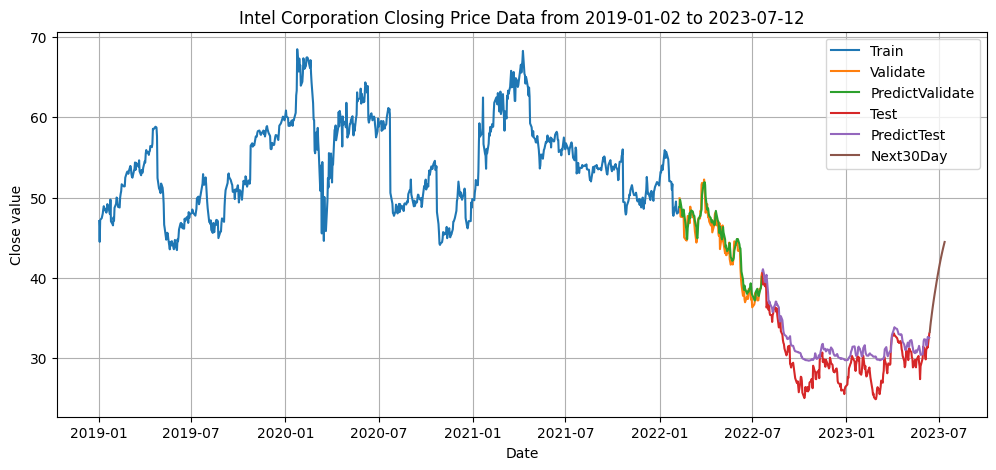

In [20]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size : train_size + val_size], y_pred_val)

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size : ], loaded_best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Day'])

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_INTC.png')
plt.show()